In [50]:
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt

# Introduction to Ensemble Methods

Ensemble methods are techniques for obtaining better predictive performances by using multiple models.

The following dataset comes from a bank which would like to know when a new client arrives if this client will subscribe to a long term deposit.

The bank will be considered as your client in the following parts.

---

**Feel free to create sklearn Pipelines for simplifying the following experiments** 

**WARNING**:
- The dataset is quite complicated, so don't be shocked if you have poor results with some relevant metrics

## Introducing and exploring the dataset

The dataset is located in `../data/bank-full.csv`. It has 17 columns, the target column or $ŷ$ is the column named `y`.

Columns summary  : 

| column name | simple description |
|-------------|------------------------|
| age | age |
| job | type of job |
| marital | marital status |
| education | education level |
| default | has credit in default? |
| housing | has housing loan? |
| contact | contact communication |
| month | last contact month of year |
| day_of_week | last contact day of the week |
| duration |  last contact duration in seconds |
| campaign |  number of contacts performed during campaign for this client |
| pday | number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted) |
| previous | number of contacts performed before this campaign and for this client |
| poutcome | outcome of the previous marketing campaign |
| **output :** |  |
| y | has  the client subscribed a term deposit? |

Let's explore the dataset a bit using pandas.

While exploring the dataset it is recommended to create a list of categorical features

In [51]:
import pandas as pd

Create a dataframe with the dataset `../data/bank-full.csv`

In [52]:
# code here
df = pd.read_csv('../data/bank-full.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Describe the dataset informations

In [53]:
# code here
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Use histogramms to display the features' distribution

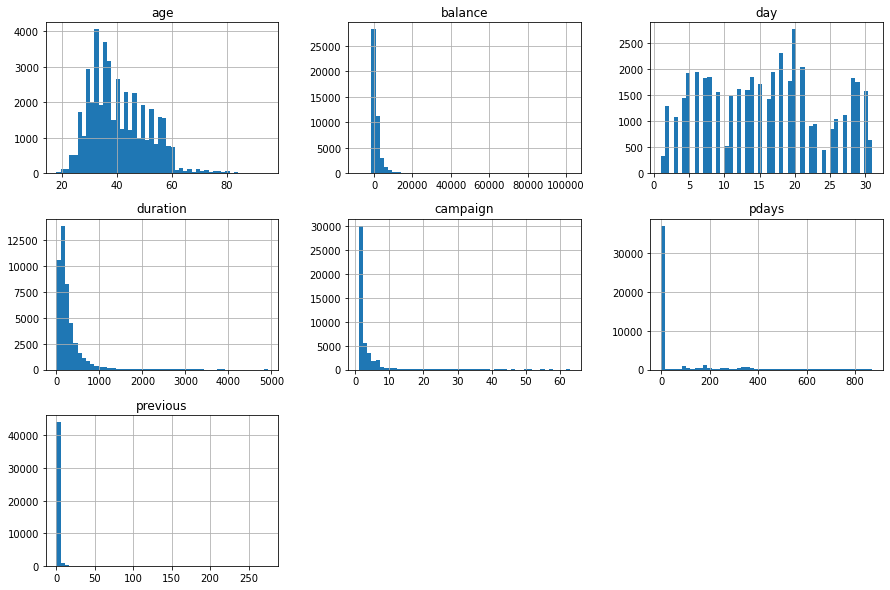

In [54]:
# code here
df.hist(figsize=(15, 10), bins=50);

Use heatmap to display the numerical features' correlation

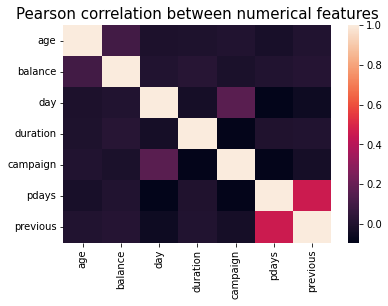

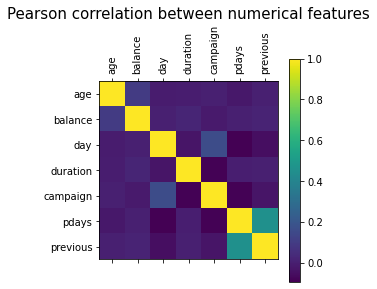

In [55]:
# code here
from seaborn import heatmap
import matplotlib.pyplot as plt

# with seaborn
ax = heatmap(df.corr())
ax.set_title('Pearson correlation between numerical features', size=15);

# With matplot lib
plt.matshow(df.corr()) # without seaborn
plt.title('Pearson correlation between numerical features', size=15)
feature_names = df.select_dtypes(include='number').columns
plt.xticks(
    ticks=range(len(feature_names)),
    labels=df.select_dtypes(include='number').columns,
    rotation=90
    );
plt.yticks(
    ticks=range(len(feature_names)),
    labels=df.select_dtypes(include='number').columns,
    );
plt.colorbar()

In order to continue the preprocessing, the features `day` and `month` should be merged into one column named `dayoftheyear`.

You can use pandas datetime tools or python datetime librairies for doing this preprocessing.
(the default year used will be 1984)

In [56]:
from datetime import datetime

In [57]:
# code here
# When you can concatenate multiple Series containing string by just summing them.
# However, be sure each Serie contains string, in case use .astype(str)
parser = lambda x: datetime.strptime(x, '%d-%b-%Y')
dayoftheyear = (df.day.astype(str) + '-' + df.month.astype(str) + '-' + '1984').apply(parser).dt.dayofyear
dayoftheyear.head()

0    126
1    126
2    126
3    126
4    126
dtype: int64

Now sort the features into categorical and numerical features

In [58]:
df_ = df.drop(columns=['day', 'month'])
df_['dayoftheyear'] = dayoftheyear
df_.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,dayoftheyear
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,126
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,126
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,126
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,126
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,126


After a first exploration, categorical/ordinal features need to be encoded in order to become a valid input for the modeling phase.

The different encoders can be found [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).

(You can also use the function `get_dummies` of pandas for categorical features)

The best approach is:
- to treat features differently from target/label information.
- to use ordinal encoder if there is hiearchy or order in category (rank, stars, qualitative evaluation)
- otherwise use one hot encoder

**Warning**
- if you have too much non ordinal categorical features, it could lead you to huge sparse matrix (matrix full of 0) with a lot of dimension very difficult to be treated through machine learning model.
- you have to deal with contraints in a unperfect world with unperfect data with unperfect human or sensor! Endure this! it is your job to understand enough what is going on and constraints to have trust in your own work!!!

In [59]:
# dayoftheyear is not a real numerical feature. The seasonality in machine learning is a specific (and very important) topic not tackle in this module/notebook
# consider dayoftheyear as numerical.

# if there is hierarchy or rank dimension in an categorical feature => use ordinal encoder
# otherwise use onehot encoder
# suprisingly sometimes, ordinal encoder for non ordinal categorical features could provide better results through ML model.
# Be prepared to see some suprisingly, weird or awesome stuffs in Machine learning.

categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'dayoftheyear']

target_name = 'y'

In [60]:
# import and create the appropriate encoders 
pd.get_dummies(df_[categorical_features]).head()
# OK it's cool, you have numerical categories but it will be hard to understand the semantic of the encoding.

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,0,0,0,1,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,1,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


# Explore with Ordinal Encoding

**WARNING**  

**Prefer here the one hot encoding** (next section) because it respect much more the quality of the data that is not ordinal. But try it!  

I let this code here for example.  

Code for one hot encoding is in the next section below ;)

## Encode your data

In [61]:
# Other solution
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
encoder.fit(df_[categorical_features])

tmp = encoder.transform(df_[categorical_features]) # return an array and not a dataframe
tmp = pd.DataFrame(tmp, columns=categorical_features)
new_df = pd.concat([tmp, df_[numerical_features]], axis=1).reindex(df_.columns, axis=1)
new_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,dayoftheyear
0,58,4.0,1.0,2.0,0.0,2143,1.0,0.0,2.0,261,1,-1,0,3.0,NaN,126
1,44,9.0,2.0,1.0,0.0,29,1.0,0.0,2.0,151,1,-1,0,3.0,NaN,126
2,33,2.0,1.0,1.0,0.0,2,1.0,1.0,2.0,76,1,-1,0,3.0,NaN,126
3,47,1.0,1.0,3.0,0.0,1506,1.0,0.0,2.0,92,1,-1,0,3.0,NaN,126
4,33,11.0,2.0,3.0,0.0,1,0.0,0.0,2.0,198,1,-1,0,3.0,NaN,126


In [62]:
# the solution above is not elegant and prompt to errors
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# maybe it already exists in sklearn,
# but sometimes it is faster to code directly :)
# for exploration or explainatory example is it ok, but for development it is a very bad habbit.
# ALWAYS REUSE existing code in development!!
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X

preprocessor  = ColumnTransformer(
    [('cat', OrdinalEncoder(), categorical_features),
     ('num', IdentityTransformer(), numerical_features)]
)
preprocessor.fit(df_)

ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'poutcome']),
                                ('num', IdentityTransformer(),
                                 ['age', 'balance', 'duration', 'campaign',
                                  'pdays', 'previous', 'dayoftheyear'])])

In [63]:
new_columns = categorical_features+numerical_features
# carefull, preprocessor transform first cat then num features and concat them.
new_df_ = pd.DataFrame(preprocessor.transform(df_), columns=new_columns).reindex(df_.columns) # so reindex the columns

In [64]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder

# much more elegant
# I use label encoder to play with loop and dict etc...
# but prefer use OrdinalEncoder for features. Remember, Less is more and reuse code
# as much as possible.
class MultiColumnLabelEncoder(TransformerMixin, BaseEstimator):
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode
        self.encoders = {}

    def fit(self, X:pd.DataFrame, y=None):
        ''' Fit one encoder for each column of interest
        with LabelEncoder.
        '''
        if self.columns is not None:
            for col in self.columns:
                encoder = LabelEncoder().fit(X[col])
                self.encoders[col] = encoder
        return self

    def transform(self, X:pd.DataFrame):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = self.encoders[col].transform(output[col].values)
        else:
            for colname, col in output.iteritems():
                output[colname] = self.encoders[colname].transform(output[colname].values)
        return output

    def fit_transform(self, X: pd.DataFrame, y=None):
        return self.fit(X, y).transform(X)

In [65]:
encoder = MultiColumnLabelEncoder(columns=categorical_features)
encoder.fit(df_.drop(columns='y')) # do not encode df_ with the target, it will be treated outside
df_enc = encoder.transform(df_.drop(columns='y'))
df_enc.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,dayoftheyear
0,58,4,1,2,0,2143,1,0,2,261,1,-1,0,3,126
1,44,9,2,1,0,29,1,0,2,151,1,-1,0,3,126
2,33,2,1,1,0,2,1,1,2,76,1,-1,0,3,126
3,47,1,1,3,0,1506,1,0,2,92,1,-1,0,3,126
4,33,11,2,3,0,1,0,0,2,198,1,-1,0,3,126


You could use also `OrdinalEncoder` for feature and `LabelEncoder` for target.

In [66]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()
labels = target_encoder.fit_transform(df_[target_name])
pd.Series(labels).value_counts()

0    39922
1     5289
dtype: int64

In [67]:
# Create the X and y DataFrames resample the dataframes if necessary
X = df_enc.copy()
y = pd.Series(labels, index=df_enc.index).copy()

0    0.883015
1    0.116985
dtype: float64


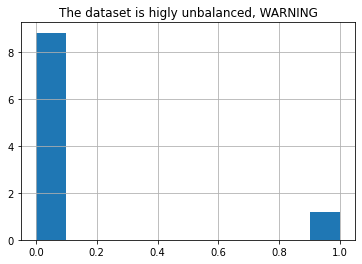

In [68]:
print(y.value_counts()/y.shape[0]) # look at the proportion of labels
ax = y.hist(density=True)
ax.set_title("The dataset is higly unbalanced, WARNING")
plt.show();

At the end of this part, two dataframes are created :

- `X` containing the features (or the matrix $X$)
- `y` containing the label (or $ŷ$)

Display the shape of X and y

In [69]:
# look at the columns, do not let y or something weird as day or month
list(X.columns)

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'dayoftheyear']

In [70]:
# code here
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (45211, 15)
Shape of y: (45211,)


Well done! The data is now ready to be splitted into sets and used to train models!

### Modelling phase with ordinal encoding

The client needs two features :

1. A model, which can be updated without performance loss.
2. A model, that performs well.

In order to highlight decision trees advantages and drawbacks, remove the `duration` column from the `X` dataset.  
`duration` is not a predictor/causal factor. It is when people seems to have problem, they are called. This information represent a potential **consequence** of default.  
- remove `duration`.

[See reference](https://archive.ics.uci.edu/ml/datasets/bank+marketing)  

> 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and **should be discarded if the intention is to have a realistic predictive model.**)

In [71]:
# remove duration column
X = X.drop(columns='duration')

Before beginning the modelling phase let's split the dataset into one training set and one testing set.

In [72]:
# train_test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =\
     train_test_split(
         X, # your features
         y, # your labels
         stratify=y, # be sure train and test set have same proportion of yes/no labels
         random_state=42, # to reproduced the same results, be sure to use the same randomization
         )

### Simple Decision Tree

We will experiment both feature by doing the two following steps.

* Training the Decision Tree model with various splits of the dataset (change the `seed` parameter of the `train_test_split` function for obtaining the second dataset)
* The decision tree `max_depth` will be fixed at 3 

if you need more info you can take a look at the [sklearn decision tree doc](https://scikit-learn.org/stable/modules/tree.html).

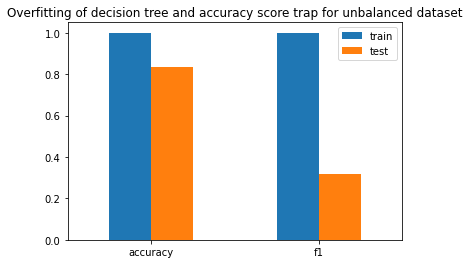

In [73]:
# just for fun let overfit decision tree which is a VERY WEAK but explainable model
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_train = dtc.predict(X_train)
y_pred = dtc.predict(X_test)
# plot_tree(dtc); DON'T PLOT, IT TAKES TOO MUCH TIME BECAUSE THE TREE IS TOO DEPTH AND COMPLEX

scores = dict(
    train= dict(
        accuracy = accuracy_score(y_pred_train, y_train),
        f1 = f1_score(y_pred_train, y_train)
    ),
    test = dict(
        accuracy = accuracy_score(y_pred, y_test),
        f1 = f1_score(y_pred, y_test),
    )
)
pd.DataFrame.from_dict(scores).plot.bar(
    title='Overfitting of decision tree and accuracy score trap for unbalanced dataset',
    rot=0 # for x label rotation
);

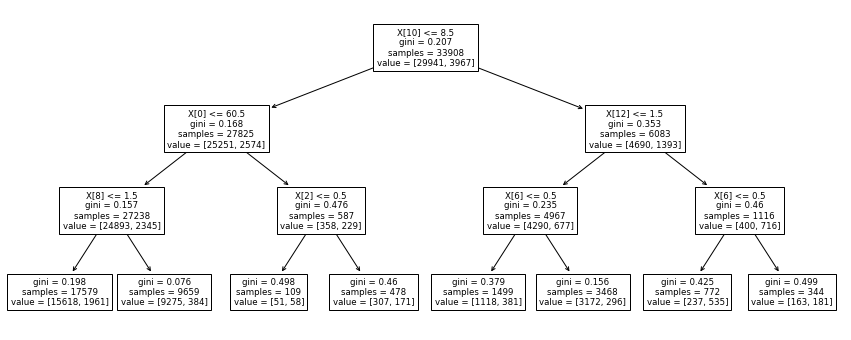

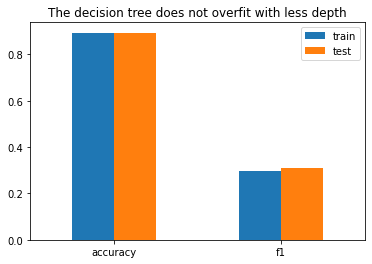

In [74]:
# to avoid overfitting, keep the decision tree simple, less specific / more general
# Decision tree model creation and tree visualization
from sklearn.tree import DecisionTreeClassifier, plot_tree

dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train, y_train)
y_pred_train = dtc.predict(X_train)
y_pred = dtc.predict(X_test)
plt.figure(figsize=(15,6))
plot_tree(dtc);

scores = dict(
    train= dict(
        accuracy = accuracy_score(y_pred_train, y_train),
        f1 = f1_score(y_pred_train, y_train)
    ),
    test = dict(
        accuracy = accuracy_score(y_pred, y_test),
        f1 = f1_score(y_pred, y_test),
    )
)
pd.DataFrame.from_dict(scores).plot.bar(
    title='The decision tree does not overfit with less depth',
    rot = 0 # for xlabel rotation
);

In [75]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8937450234451031

Look at this AWS' blog which explains which metrics to use and when:  
https://neptune.ai/blog/evaluation-metrics-binary-classification  

This blog was found with a google request:
> `machine learning best metrics for classification` (magic isn't it?)

Now, a first model has been created, change the random seed for the train/test split, and create another tree.

This tree should be created with the same hyperparameters than above. 

Accuracy score 0: 0.8903830841369548


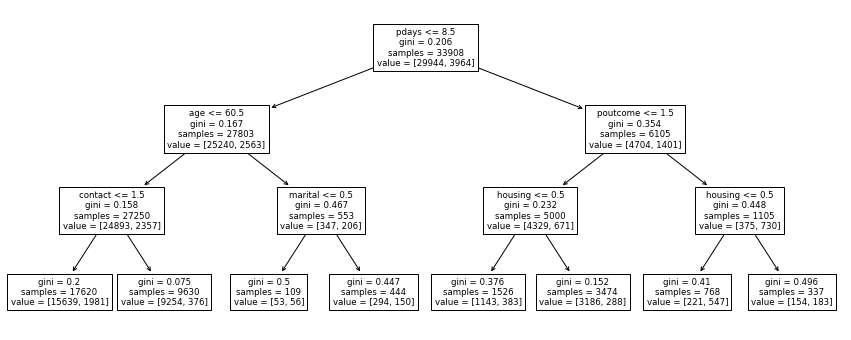

Accuracy score 1: 0.8946297443156684


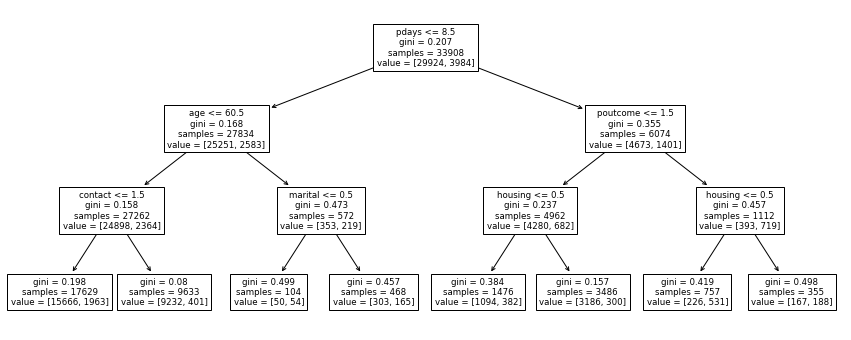

Accuracy score 2: 0.8937450234451031


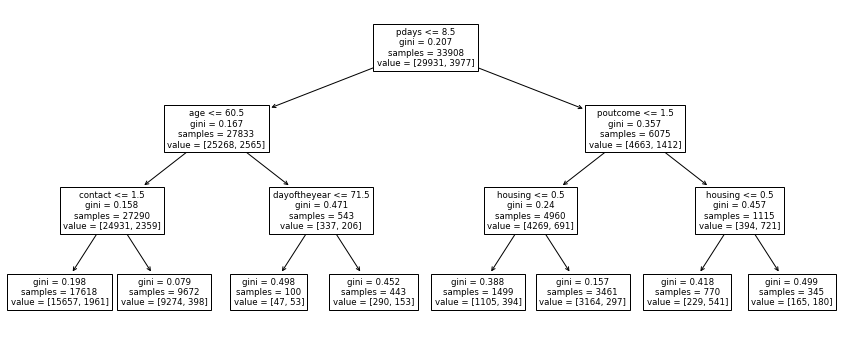

In [76]:
# OK great, now we can test with different split
# create a new train and test dataset with a different seed
# Second tree creation
seeds = range(3)

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    dtc = DecisionTreeClassifier(max_depth=3)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    print(f'Accuracy score {i}:', accuracy_score(y_test, y_pred))
    plt.figure(figsize=(15,6))
    plot_tree(dtc, feature_names=X_train.columns)
    plt.show();

In [77]:
# SHOULD WORK ON YOUR COMPUTER, BUT NOT WORK ON MINE BECAUSE OF MY ENVIRONMENT
# import graphviz
# from sklearn import tree

# dot_data = tree.export_graphviz(
#     model, out_file=None,
#     feature_names=X.columns,
#     class_names=pd.unique(encoder.encoders['y'].inverse_transform(y)),
#     filled=True, rounded=True,
#     special_characters=True,
#     )
# graph = graphviz.Source(dot_data)  
# graph

What can you tell about the two trees?

**Results are quite similar but the performance are not very high.**

Normally, before creating a model, one or more evaluation metrics should be chosen depending of the client problem.

* Choose two different metrics from this article : [model evaluation](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).

* Or this one again: https://neptune.ai/blog/evaluation-metrics-binary-classification 

* Prepare a scoring list for these metrics.

* Use the cross-validation method to measure these metrics (if you need see : [cross validation sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)). 

*Hint:*  the `cross_validate` method allows you to pass a metric list as parameter (see [doc here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) ).

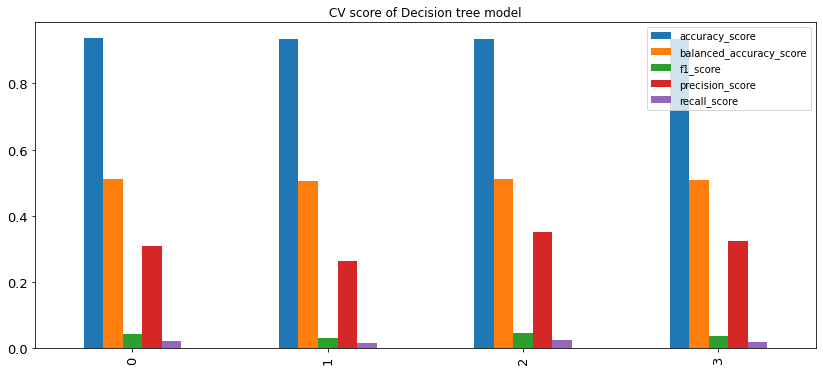

In [78]:
# FIRST APPROACH
# with manual cross validation
# more flexible for exotic code
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, balanced_accuracy_score
)
from sklearn.model_selection import StratifiedKFold

# SPLIT YOUR DATASET
X_train, X_test, y_train, y_test =\
     train_test_split(X, y, stratify=y, random_state=42)

# List your function (could be partial function or lambda function is they need key-word params)
score_list = [accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score]

# build your fold generator
# shuffle or not? Always shuffle if you do not know :)
# to be sure each kfold is similar regarding label yes/no proportion
# stratifiedKFold guarantee to split Kfold with same proportion.
skf = StratifiedKFold(n_splits=4, shuffle=True)

# cross-validate your model
results = []
for train_idx, valid_idx in skf.split(X_train, y_train):
    X_train_ = X.iloc[train_idx]
    X_valid = X.iloc[valid_idx]

    y_train_ = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]

    dtc = DecisionTreeClassifier(max_depth=3)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_valid)

    result = {func.__name__:func(y_valid, y_pred) for func in score_list}
    results.append(result)

# performance plot
(pd.DataFrame(results)
    .plot.bar(title="CV score of Decision tree model",
              fontsize=13,
              figsize=(14, 6))
);

- Bad results in cross validation, do not even test with X_test. It is useless
- but what happens if we do not shuffle?

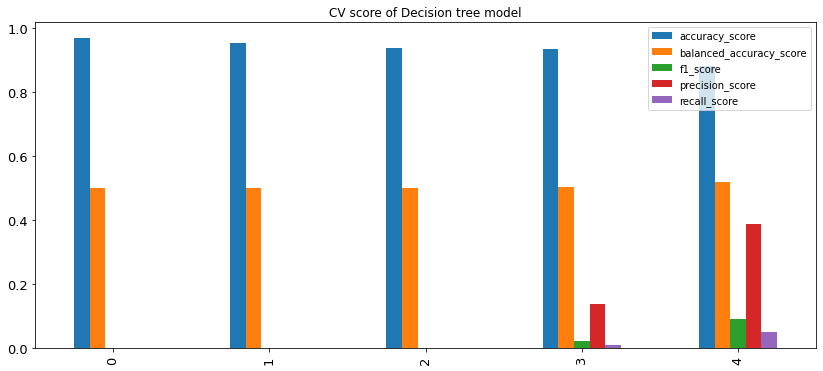

In [79]:
from sklearn.model_selection import StratifiedKFold

# WITHOUT SHUFFLE
skf = StratifiedKFold(n_splits=5)

results = []

for train_idx, valid_idx in skf.split(X_train, y_train):
    X_train_ = X.iloc[train_idx]
    X_valid = X.iloc[valid_idx]

    y_train_ = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]

    dtc = DecisionTreeClassifier(max_depth=3)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_valid)

    result = {func.__name__:func(y_valid, y_pred) for func in score_list}
    results.append(result)

# performance plot
pd.DataFrame(results).plot.bar(title="CV score of Decision tree model", fontsize=13, figsize=(14, 6));

**Observation**
- warning: accuracy score is not the best metric for unbalanced dataset
- prefer shuffle the dataset to keep train and test set representatives of the same reality.
- prefer to use different metrics such as f1 score, precision, recall, matthews etc...
- the model provides poor results

In [80]:
# SECOND APPROACH MORE FASTER, with cross_validate
from sklearn.metrics import SCORERS

# look at metric key
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

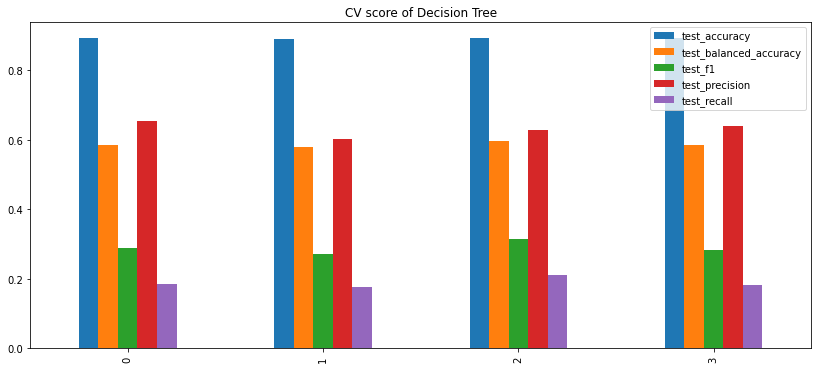

In [81]:
from sklearn.model_selection import cross_validate

score_list = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
cv_results = cross_validate(dtc, X_train, y_train, cv=4, scoring=score_list)
pd.DataFrame.from_dict(cv_results).iloc[:, 2:].plot.bar(figsize=(14, 6), title='CV score of Decision Tree');

**Observation**
- Poor performance
- unbalanced dataset that is problematic there

# Explore with One Hot Encoding

Here same thing as above but with OneHot encoding.  

Here we treat y as label and the rest of data as features.

In [82]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'dayoftheyear'] # to be completed
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'] # to be completed

In [83]:
# import and create the appropriate encoders 
pd.get_dummies(df_[categorical_features]).head()
# OK it's cool, you have numerical categories but it will be hard to understand the semantic of the encoding.

,dayoftheyear,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,126,0,0,0,0,1,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1
1,126,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1
2,126,0,0,1,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
3,126,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,1
4,126,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [84]:
df_enc = pd.concat([
    pd.get_dummies(df_[categorical_features]),
    df_[numerical_features], 
], axis=1)

Now, the dataset needs to be split into two sets :
1. one corresponding to $ŷ$ 
2. the other corresponding to the $X$ matrix.

- Prepare the learning dataset

In [85]:
# Create the X and y DataFrames resample the dataframes if necessary
y = df_.y.replace({'yes':1, 'no':0})
X = df_enc

At the end of this part, two dataframes are created :

- `X` containing the features (or the matrix $X$)
- `y` containing the label (or $ŷ$)

Display the shape of X and y

In [86]:
# code here
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (45211, 39)
Shape of y: (45211,)


Well done! The data is now ready to be splitted into sets and used to train models!

## Modelling phase with one hot encoding

The client needs two features :

1. A model, which can be updated without performance loss.
2. A model, that performs well.

In order to highlight decision trees advantages and drawbacks, remove the `duration` column from the `X` dataset.

In [87]:
# remove duration column
X = X.drop(columns='duration')

Before beginning the modelling phase let's split the dataset into one training set and one testing set.

In [88]:
# train_test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, train_size=0.7)

### Simple Decision Tree

We will experiment both feature by doing the two following steps.

* Training the Decision Tree model with various splits of the dataset (change the `seed` parameter of the `train_test_split` function for obtaining the second dataset)
* The decision tree `max_depth` will be fixed at 3 

if you need more info you can take a look at the [sklearn decision tree doc](https://scikit-learn.org/stable/modules/tree.html).

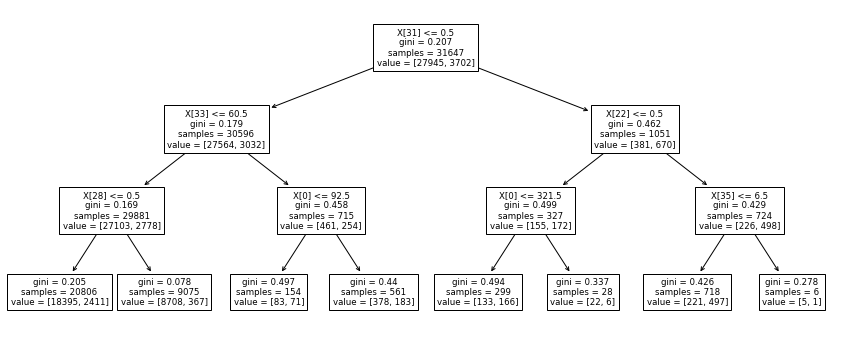

In [89]:
# Decision tree model creation and tree visualization
from sklearn.tree import DecisionTreeClassifier, plot_tree

dtc = DecisionTreeClassifier(max_depth=3)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_test)
plt.figure(figsize=(15,6))
plot_tree(dtc);

In [90]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.8947213211442052

Now, a first model has been created, change the random seed for the train/test split, and create another tree.

This tree should be created with the same hyperparameters than above. 

Accuracy score 0: 0.8901176678757852


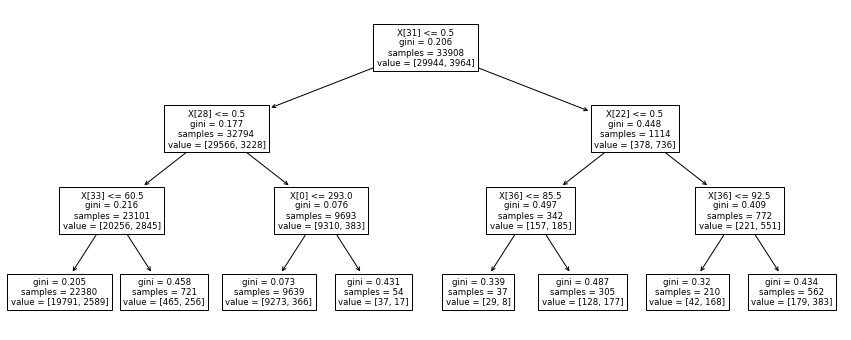

Accuracy score 1: 0.8951605768380076


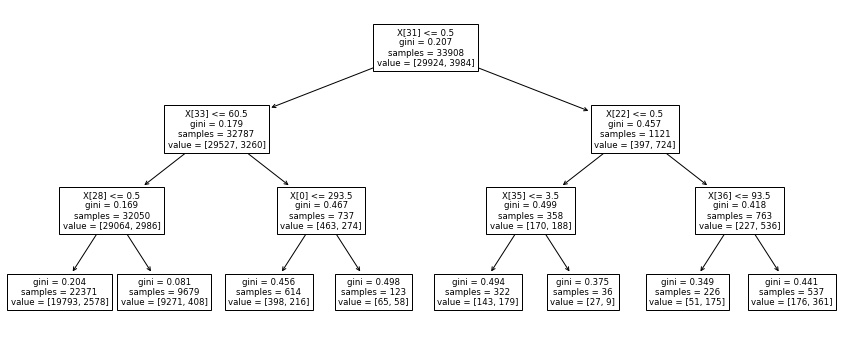

Accuracy score 2: 0.8942758559674423


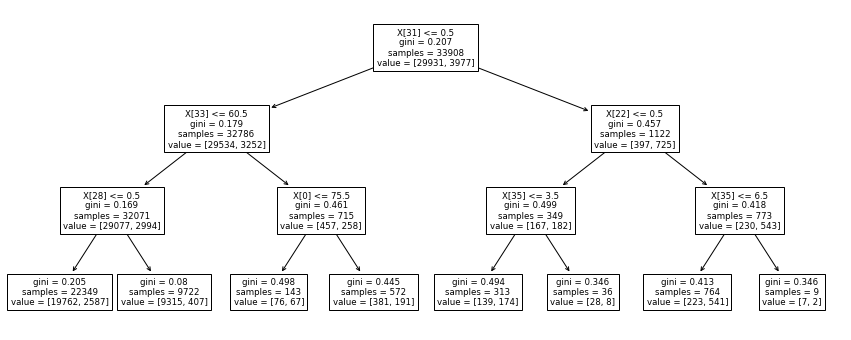

In [91]:
# OK great, now we can test with different split
# create a new train and test dataset with a different seed
# Second tree creation
seeds = range(3)

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
    dtc = DecisionTreeClassifier(max_depth=3)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_test)
    print(f'Accuracy score {i}:', accuracy_score(y_test, y_pred))
    plt.figure(figsize=(15,6))
    plot_tree(dtc)
    plt.show();

In [92]:
# import graphviz
# from sklearn import tree

# dot_data = tree.export_graphviz(
#     model, out_file=None,
#     feature_names=X.columns,
#     class_names=pd.unique(encoder.encoders['y'].inverse_transform(y)),
#     filled=True, rounded=True,
#     special_characters=True,
#     )
# graph = graphviz.Source(dot_data)  
# graph 

What can you tell about the two trees?

**Results are quite similar but the performance are not very high.**

Normally, before creating a model, one or more evaluation metrics should be chosen depending of the client problem.

* Choose two different metrics from this article : [model evaluation](https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234).

* Prepare a scoring list for these metrics.

* Use the cross-validation method to measure these metrics (if you need see : [cross validation sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)). 

*Hint:*  the `cross_validate` method allows you to pass a metric list as parameter (see [doc here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) ).

In [93]:
# Cross validation on Decision trees
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

score_list = [accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score]

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, train_size=0.7)

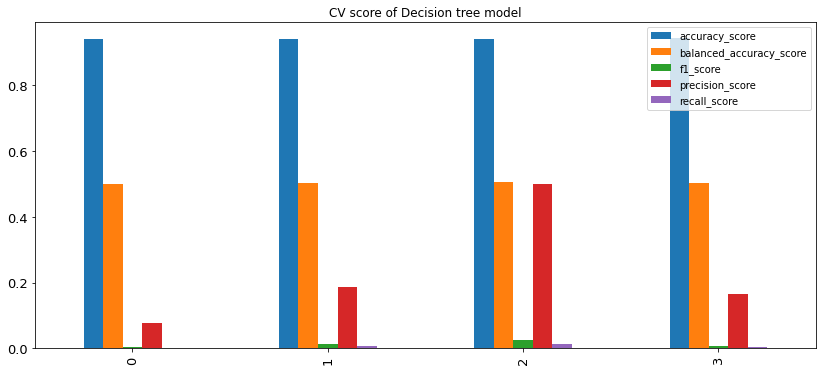

In [95]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=True)

results = []

for train_idx, valid_idx in skf.split(X_train, y_train):
    X_train_ = X.iloc[train_idx]
    X_valid = X.iloc[valid_idx]

    y_train_ = y.iloc[train_idx]
    y_valid = y.iloc[valid_idx]

    dtc = DecisionTreeClassifier(max_depth=3)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_valid)

    result = {func.__name__:func(y_valid, y_pred) for func in score_list}
    results.append(result)

# performance plot
pd.DataFrame(results).plot.bar(title="CV score of Decision tree model", fontsize=13, figsize=(14, 6));

0    0.883015
1    0.116985
Name: y, dtype: float64


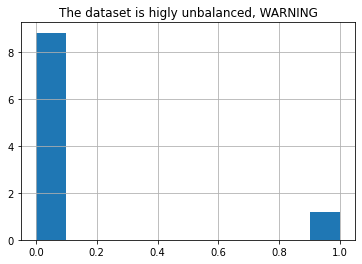

In [96]:
print(y.value_counts()/y.shape[0]) # look at the proportion of labels
ax = y.hist(density=True)
ax.set_title("The dataset is higly unbalanced, WARNING")
plt.show();

**Observation**
- warning: accuracy score is not the best metric for unbalanced dataset
- prefer shuffle the dataset to avoid to train only on the majority class!!
- prefer to use different metrics such as f1 score
- the model provides poor results

In [97]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

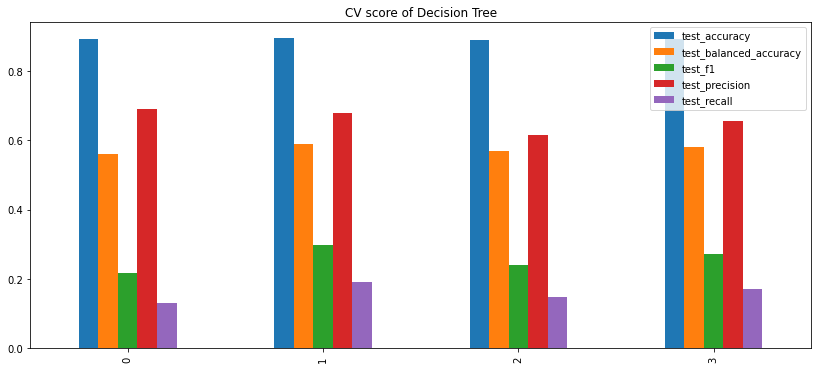

In [98]:
from sklearn.model_selection import cross_validate

score_list = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']
cv_results = cross_validate(dtc, X_train, y_train, cv=4, scoring=score_list)
pd.DataFrame.from_dict(cv_results).iloc[:, 2:].plot.bar(figsize=(14, 6), title='CV score of Decision Tree');

**Observation**
- Poor performance
- unbalanced dataset that is problematic there
- same conclusion than ordinal encoder

In [99]:
X.head()

,dayoftheyear,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,age,balance,campaign,pdays,previous
0,126,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,58,2143,1,-1,0
1,126,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,44,29,1,-1,0
2,126,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,33,2,1,-1,0
3,126,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,47,1506,1,-1,0
4,126,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,33,1,1,-1,0


# Ensemble

### Introducing Ensemble Learning with Bagging models.

Let's train multiple classifiers in parallel in a bootstraping approach! 

Bagging stands for ***Boostrap AGGregatING***.

(if you need a reminder of statistical bootstraping take a short look on [Wikipedia](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) )

The following [post](https://blog.octo.com/les-methodes-ensemblistes-pour-algorithmes-de-machine-learning/) will give you an overview of these methods and their advantages and drawbacks

**The train test split using a seed equals to 42 will be used in the following part**

In [100]:
# train_test split (you can copy paste the previously declared cell)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

#### Using Random Forest

The concept of random forest is explained in this [post](https://medium.com/analytics-vidhya/understanding-the-random-forest-algorithm-79b87bdde79a).

Now the best parameters of the previous classifier will be used in a using a bagging classifier
[sklearn : Random Forest Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

We will use grid search on the `n_estimators` parameter. (select 4 values in the range \[5-100\] ) 

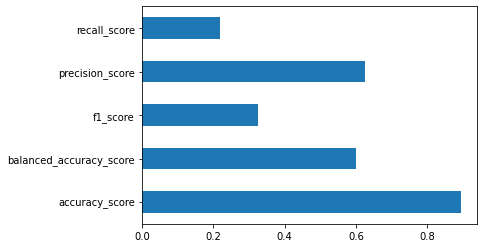

In [101]:
# gridsearch for the Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

score_list = [
    accuracy_score,
    balanced_accuracy_score,
    f1_score, precision_score,
    recall_score
    ]
result = {func.__name__:func(y_test, y_pred) for func in score_list}
pd.Series(result).plot.barh();

In [102]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier()
param_grid = dict(n_estimators=range(10, 110, 20))
score_list = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']

exp = GridSearchCV(rfc, scoring=score_list, param_grid=param_grid, refit='f1')
exp.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': range(10, 110, 20)}, refit='f1',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall'])

In [103]:
best_rfc = exp.best_estimator_

In [104]:
exp.cv_results_

{'mean_fit_time': array([0.1756813 , 0.50113392, 0.8384409 , 1.07335944, 1.40807076]),
 'std_fit_time': array([0.00518594, 0.01821336, 0.0145787 , 0.01755488, 0.02426761]),
 'mean_score_time': array([0.01773982, 0.0379952 , 0.05580645, 0.07328076, 0.09173584]),
 'std_score_time': array([0.00051224, 0.003125  , 0.00204929, 0.00247645, 0.00184464]),
 'param_n_estimators': masked_array(data=[10, 30, 50, 70, 90],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10},
  {'n_estimators': 30},
  {'n_estimators': 50},
  {'n_estimators': 70},
  {'n_estimators': 90}],
 'split0_test_accuracy': array([0.88779121, 0.89339428, 0.8901504 , 0.89324683, 0.89383663]),
 'split1_test_accuracy': array([0.88513713, 0.88911825, 0.89118254, 0.8898555 , 0.89191979]),
 'split2_test_accuracy': array([0.88675907, 0.89103509, 0.8895606 , 0.8895606 , 0.89029785]),
 'split3_test_accuracy': array([0.88644743, 0.88792214, 0.88983926

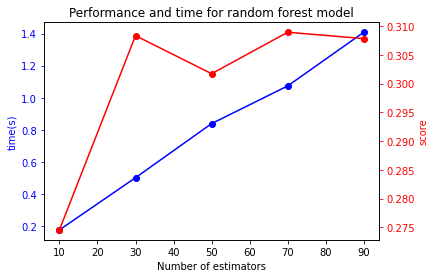

In [105]:
tmp = pd.DataFrame({k:v for k,v in exp.cv_results_.items() if k in ['mean_fit_time', 'mean_test_f1']},
             index = [v['n_estimators'] for v in exp.cv_results_['params']])
ax = tmp.mean_fit_time.plot(marker='o', color='blue')
ax1 = ax.twinx()
tmp.mean_test_f1.plot(marker='o', ax=ax1, color='red')

ax.tick_params(axis='y', colors='blue')
ax.set_title('Performance and time for random forest model')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('time(s)', color='blue')

ax1.tick_params(axis='y', colors='red')
ax1.set_ylabel('score', color='red');

How much estimators should we use for obtaining an optimal result? (in terms of time and performance)

*The best model in terms of time and performance is not the model with the maximum estimators.*  
Here I would choose 30 estimators if time would be limited. But for the example, I prefer to keep the best from CV grid.

Now, cross validate the Random forest classifier with the selected metric used with the Decision Trees.

In [106]:
# cross validation
cv_results = cross_validate(best_rfc, X_train, y_train, scoring=score_list)

Display cross validation results

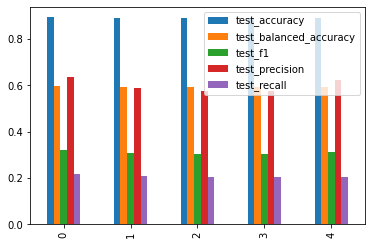

In [107]:
# evaluation curves
pd.DataFrame(cv_results).iloc[:, 2:].plot.bar();

#### Other Random Forest effect

The random forest model can attribute an importance value to features, [explanations here](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)

Let's train another random forest and display an histogramm with it :

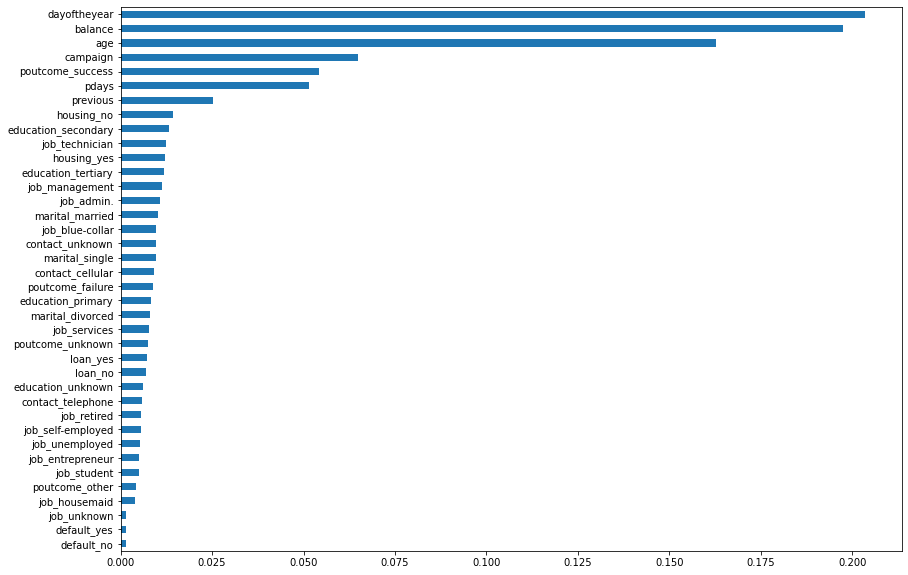

In [108]:
# training and display features' importance.
# tell them to use the RandomForest Object
best_rfc.fit(X_train, y_train)

(pd.Series(best_rfc.feature_importances_, index=X.columns)
    .sort_values()
    .plot.barh(figsize=(14, 10))
);

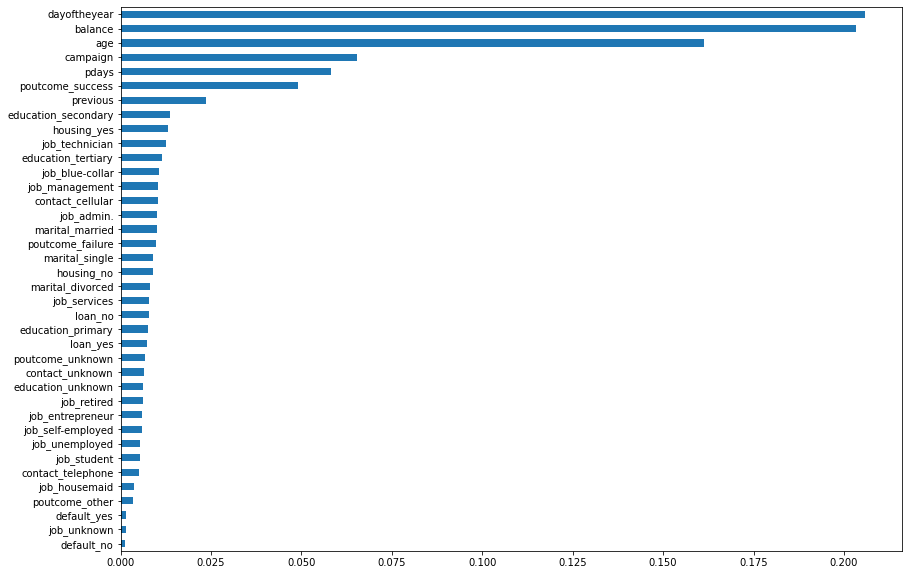

In [109]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)

(pd.Series(rfc.feature_importances_, index=X.columns)
    .sort_values()
    .plot.barh(figsize=(14, 10))
);

What is the most important feature?

*Day of the year and balance are the most important features regarding the number of predictors.*

We removed the duration feature in our dataset

Read this feature description on the dataset description ([here on data.world](https://data.world/uci/bank-marketing) or [here on kaggle](https://www.kaggle.com/janiobachmann/bank-marketing-dataset)).

How would the previously trained models perform with this feature?

*The `duration` feature is highly correlated with the target `y` but is not a predictor.*  
*In fact, customers are called only where they have problems, but the fact they are called or not is not a predictor of their situation*  
  
*Due to the high correlation, `duration` would get a hight feature importance score despite being not a predictor.* 


### Continue Ensemble Learning with boosting techniques

Bagging permits to average the results of separated models, whereas the boosting technique trains a classifier and optimizes it in function of its error.

Some information about boosting techniques are on the [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) but a commonly used library for these techniques is [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) there are some compatibilities with the sklearn methods (gridsearch, cross validation,...)

- install the `xgboost` package

*Read the articles in resources for a complete explanation.*

In this part a classifier will be trained and evaluated.

In [110]:
# use the same split and seed than you used before
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

*Hint:* An example for integrating `XGBoost` with  the `sklearn` tools is available [here](https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a)

In [111]:
from xgboost import XGBRFClassifier

clf = XGBRFClassifier(n_estimators=50)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('f1_score:', f1_score(y_test, y_pred))

/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


f1_score: 0.30416911332941865


Let's build a new model than before with a grid search on the parameter `n_estimators`.

In [112]:
# model building and evaluation
param_grid = dict(n_estimators=range(10, 110, 20))
score_list = ['accuracy', 'balanced_accuracy', 'f1', 'precision', 'recall']

exp = GridSearchCV(clf, scoring=score_list, param_grid=param_grid, refit='f1')
exp.fit(X_train, y_train)

GridSearchCV(estimator=XGBRFClassifier(base_score=0.5, booster='gbtree',
                                       callbacks=None, colsample_bylevel=1,
                                       colsample_bytree=1,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, gamma=0, gpu_id=-1,
                                       grow_policy='depthwise',
                                       importance_type=None,
                                       interaction_constraints='', max_bin=256,
                                       max_cat_to_onehot=4, max_delta_step=0,
                                       max_depth=6, max_l...0,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=50, n_jobs=0,
                                 

In [113]:
best_clf = exp.best_estimator_

Now cross validate the selected model and display the performance curves

In [114]:
# cross validation
cv_results = cross_validate(best_clf, X_train, y_train, scoring=score_list)

<AxesSubplot:>

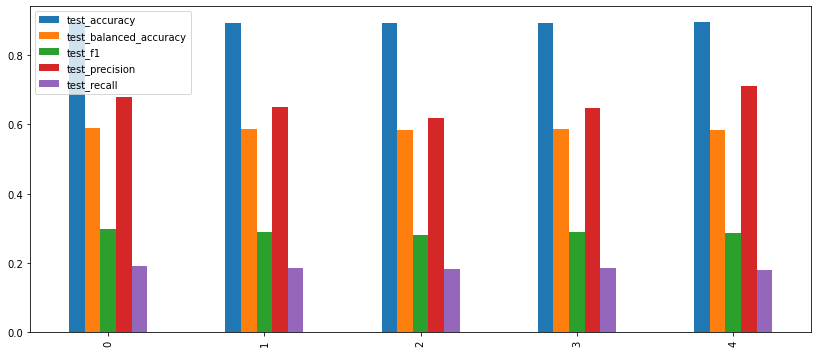

In [115]:
# performance curves
pd.DataFrame(cv_results).iloc[:, 2:].plot.bar(figsize=(14, 6))

## Let's Conclude

Before writing a memo, use your classifiers on the test set and display evaluation metrics 

In [116]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

In [117]:
# Decision Tree on test set
# Decision Tree on test set
dtc = DecisionTreeClassifier()
gs_dt = GridSearchCV(dtc, param_grid={'max_depth':[3,5,7]},cv=10)
gs_dt.fit(X_train, y_train)
dt_class = gs_dt.best_estimator_
y_pred_dt=dt_class.predict(X_test)

accuracy_score(y_test, y_pred_dt), f1_score(y_test, y_pred_dt), \
recall_score(y_test, y_pred_dt), precision_score(y_test, y_pred_dt)

(0.8936565513580466,
 0.29043683589138136,
 0.18608169440242056,
 0.6612903225806451)

In [118]:
# Random forest on test set
rfc = RandomForestClassifier()
gs_rfc = GridSearchCV(rfc, param_grid={'max_depth':range(5, 110, 25)}, cv=10)
gs_rfc.fit(X_train, y_train)
best_rfc = gs_rfc.best_estimator_
y_pred_rf=best_rfc.predict(X_test)

accuracy_score(y_test, y_pred_rf), f1_score(y_test, y_pred_rf), \
recall_score(y_test, y_pred_rf), precision_score(y_test, y_pred_rf)

(0.8937450234451031,
 0.24227129337539435,
 0.14523449319213314,
 0.7300380228136882)

In [119]:
# XGBoost on test set
xgbc = XGBRFClassifier()
gs_xgb = GridSearchCV(xgbc, param_grid={'max_depth':range(5, 110, 25)}, cv=10)
gs_xgb.fit(X_train, y_train)
best_xgb = gs_xgb.best_estimator_
y_pred_xgb=best_xgb.predict(X_test)

accuracy_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_xgb), \
recall_score(y_test, y_pred_xgb), precision_score(y_test, y_pred_xgb)

(0.8943643280544988,
 0.2841726618705036,
 0.17927382753403934,
 0.684971098265896)

What do you notice?

- The XGBoost works better.
- the dataset is very difficult to generalize by tree or ensemble tree models

- Write your memo about bagging and boosting method in a cell below.
- Which model would you choose for the bank, and why?

you can add your models result visualization in this cell if it helps you explaining your conclusions.

                                 `write memo here`

## To go further

### Build a customized bagging classifier (Optional) 

- Use a different classification model you have seen until now and build a new classifier based on the [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) to create and train an new model.
- Use differents classification models and use the [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) to create and train an new model.

In [120]:
# Write your code here

## Resample the data

Before going through the modelling phase, let's see the label distribution :

Use the `value_counts` function and the appropriate visualization for displaying the label distribution

In [121]:
# code here

What do you notice?

*answer here*

You can find some techniques for rebalancing the data [here](https://blog.octo.com/donnees-desequilibrees-que-faire/), [here](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html).

Rebalance the data.

In [122]:
# code here